## Overview

* Create a gold_user_journey table
* Optimize the gold_user_journey table using z-ordering
* Create gold_attribution table
* View first touch vs. last touch by channel
* Upsert data into gold_user_journey and gold_attribution
* Review Delta Lake table history for auditing & governance

## Import libraries

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
database_name = "MultiTouch"
raw_data_path = "/mnt/da-global-raw-box/POC/MultiTouch"
bronze_tbl_path = "/mnt/da-global-raw-box/POC/MultiTouchBronze"

gold_user_journey_tbl_path = "/mnt/da-global-raw-box/POC/MultiTouchGoldUserJourney"
gold_attribution_tbl_path = "/mnt/da-global-raw-box/POC/MultiTouchGoldAttributes"

##### Set the current database so that it doesn't need to be manually specified each time it's used.


In [0]:
_ = spark.sql("use {}".format(database_name))

## Step 2: Create a Gold-level User Journey Table

1. Create a user journey temporary view
2. View the user journey data
3. Create and view the gold_user_journey table

* The query below aggregates each user's journey into a single row. This includes
  * `uid`: the user identifier for a given user.
  * `path`: the list of channels that impressions for a given campaign have been delivered on to a given user.
  * `first_interaction`: the first channel that an impression for a given campaign was delivered on for a given user.
  * `last_interaction`: the last channel that an impression for a given campaign was delivered on for a given user.
  * `conversion`: boolean indicating whether the given user has converted (1) or not (0).

In [0]:
%sql 
CREATE OR REPLACE TEMP VIEW user_journey_view AS
SELECT
  sub2.uid AS uid,CASE
    WHEN sub2.conversion == 1 then concat('Start > ', sub2.path, ' > Conversion')
    ELSE concat('Start > ', sub2.path, ' > Null')
  END AS path,
  sub2.first_interaction AS first_interaction,
  sub2.last_interaction AS last_interaction,
  sub2.conversion AS conversion,
  sub2.visiting_order AS visiting_order
FROM
  (
    SELECT
      sub.uid AS uid,
      concat_ws(' > ', collect_list(sub.channel)) AS path,
      element_at(collect_list(sub.channel), 1) AS first_interaction,
      element_at(collect_list(sub.channel), -1) AS last_interaction,
      element_at(collect_list(sub.conversion), -1) AS conversion,
      collect_list(sub.visit_order) AS visiting_order
    FROM
      (
        SELECT
          uid,
          channel,
          time,
          conversion,
          dense_rank() OVER (
            PARTITION BY uid
            ORDER BY
              time asc
          ) as visit_order
        FROM
          bronze
      ) AS sub
    GROUP BY
      sub.uid
  ) AS sub2;

##### View the user journey data

In [0]:
%sql
SELECT * FROM user_journey_view

uid,path,first_interaction,last_interaction,conversion,visiting_order
0000d2e87f48471a8a5b28594dc80db1,Start > Affiliates > Affiliates > Search Engine Marketing > Affiliates > Google Display Network > Search Engine Marketing > Search Engine Marketing > Affiliates > Search Engine Marketing > Null,Affiliates,Search Engine Marketing,0,"List(1, 2, 3, 4, 5, 6, 7, 8, 9)"
0002a440b9b74c488df588469372d4ff,Start > Search Engine Marketing > Google Display Network > Search Engine Marketing > Social Network > Search Engine Marketing > Null,Search Engine Marketing,Search Engine Marketing,0,"List(1, 2, 3, 4, 5)"
0003ce70677c4572be97bbbe500d9f14,Start > Social Network > Affiliates > Affiliates > Search Engine Marketing > Affiliates > Search Engine Marketing > Search Engine Marketing > Null,Social Network,Search Engine Marketing,0,"List(1, 2, 3, 4, 5, 6, 7)"
0005287d190d4637b14595fdc14792bf,Start > Email > Affiliates > Google Display Network > Social Network > Search Engine Marketing > Social Network > Null,Email,Social Network,0,"List(1, 2, 3, 4, 5, 6)"
00069361eca54b8ea52d854374177865,Start > Google Display Network > Null,Google Display Network,Google Display Network,0,List(1)
0008f57b6022488e8053f9858ff70f3e,Start > Social Network > Social Network > Search Engine Marketing > Search Engine Marketing > Affiliates > Affiliates > Null,Social Network,Affiliates,0,"List(1, 2, 3, 4, 5, 6)"
000bf5b54156457ea4689f3cd58d769b,Start > Google Display Network > Search Engine Marketing > Social Network > Search Engine Marketing > Conversion,Google Display Network,Search Engine Marketing,1,"List(1, 2, 3, 4)"
000d29d2619e4389965ee624bcca5116,Start > Social Network > Affiliates > Affiliates > Affiliates > Affiliates > Social Network > Null,Social Network,Social Network,0,"List(1, 2, 3, 4, 5, 6)"
000e14e1b0a14c209784cc762bb32301,Start > Social Network > Null,Social Network,Social Network,0,List(1)
000edc8a1f75437d90b7b175a942fda2,Start > Affiliates > Affiliates > Email > Social Network > Social Network > Search Engine Marketing > Affiliates > Social Network > Google Display Network > Null,Affiliates,Google Display Network,0,"List(1, 2, 3, 4, 5, 6, 7, 8, 9)"


##### Create and view the gold_user_journey table

In [0]:
_ = spark.sql('''
  CREATE TABLE IF NOT EXISTS `{}`.gold_user_journey
  USING DELTA 
  LOCATION '{}'
  AS SELECT * from user_journey_view
  '''.format(database_name, gold_user_journey_tbl_path))

In [0]:
%sql
select * from gold_user_journey

uid,path,first_interaction,last_interaction,conversion,visiting_order
00006b91e1634036b36ec045f5f9ccef,Start > Social Network > Social Network > Null,Social Network,Social Network,0,"List(1, 2)"
00010ade753b417d9cc356af94c124a6,Start > Affiliates > Search Engine Marketing > Search Engine Marketing > Search Engine Marketing > Search Engine Marketing > Search Engine Marketing > Search Engine Marketing > Affiliates > Null,Affiliates,Affiliates,0,"List(1, 2, 3, 4, 5, 6, 7, 8)"
0001dbe81d114aaf8c9067ff9b80cbd2,Start > Social Network > Affiliates > Email > Google Display Network > Affiliates > Search Engine Marketing > Search Engine Marketing > Social Network > Google Display Network > Null,Social Network,Google Display Network,0,"List(1, 2, 3, 4, 5, 6, 7, 8, 9)"
000386d7c75d45f1899828fcd2e2baf0,Start > Affiliates > Affiliates > Affiliates > Email > Affiliates > Search Engine Marketing > Affiliates > Null,Affiliates,Affiliates,0,"List(1, 2, 3, 4, 5, 6, 7)"
00078fb8fbc648b7adb39c0a87aec26a,Start > Affiliates > Google Display Network > Null,Affiliates,Google Display Network,0,"List(1, 2)"
000882143e6849f5830b3427940a8227,Start > Social Network > Affiliates > Affiliates > Social Network > Search Engine Marketing > Null,Social Network,Search Engine Marketing,0,"List(1, 2, 3, 4, 5)"
0009425838674691a717856b9c8e8f50,Start > Search Engine Marketing > Social Network > Null,Search Engine Marketing,Social Network,0,"List(1, 2)"
000b08f300634392a9b280ab48e66eb5,Start > Search Engine Marketing > Social Network > Affiliates > Affiliates > Conversion,Search Engine Marketing,Affiliates,1,"List(1, 2, 3, 4)"
000b1c0b867e456fa7db161e01e04a57,Start > Search Engine Marketing > Search Engine Marketing > Social Network > Search Engine Marketing > Search Engine Marketing > Social Network > Null,Search Engine Marketing,Social Network,0,"List(1, 2, 3, 4, 5, 6)"
000c52c832b341e182334aa026782818,Start > Search Engine Marketing > Null,Search Engine Marketing,Search Engine Marketing,0,List(1)


## Optimize the gold_user_journey table

In [0]:
%sql 
OPTIMIZE gold_user_journey ZORDER BY uid

path,metrics
null,"List(1, 17, List(25227596, 25227596, 2.5227596E7, 1, 25227596), List(975814, 1515992, 1466185.0, 17, 24925161), 0, List(minCubeSize(107374182400), List(0, 0), List(17, 24925161), 0, List(17, 24925161), 1, null), 1)"


## Create gold-level attribution summary table

In the table, `gold_user_journey`, that we just created in the previous step, we captured the values for `first_interaction` and `last_interaction` in their own respective columns. With this data now in place, let's take a look at attribution using the heuristic methods `first-touch` and `last-touch`. 

1. Create a temporary view for first-touch and last-touch attribution metrics
2. Use the temporary view to create the gold_attribution table
3. Use the gold_attribution table to view first touch vs. last touch by channel

After we build our Markov model in the next notebook, `04_markov_chains`, we will then take a look at how attribution using a data-driven method compares to these heuristic methods.

##### Create temporary view for first-touch and last-touch attribution metrics

In [0]:
%sql 
CREATE OR REPLACE TEMP VIEW attribution_view AS
SELECT
  'first_touch' AS attribution_model,
  first_interaction AS channel,
  round(count(*) / (
     SELECT COUNT(*)
     FROM gold_user_journey
     WHERE conversion = 1),2) AS attribution_percent
FROM gold_user_journey
WHERE conversion = 1
GROUP BY first_interaction
UNION
SELECT
  'last_touch' AS attribution_model,
  last_interaction AS channel,
  round(count(*) /(
      SELECT COUNT(*)
      FROM gold_user_journey
      WHERE conversion = 1),2) AS attribution_percent
FROM gold_user_journey
WHERE conversion = 1
GROUP BY last_interaction

##### Use the temporary view to create the gold_attribution table

In [0]:
_ = spark.sql('''
CREATE TABLE IF NOT EXISTS gold_attribution
USING DELTA
LOCATION '{}'
AS
SELECT * FROM attribution_view'''.format(gold_attribution_tbl_path))

In [0]:
%sql
SELECT * FROM gold_attribution

attribution_model,channel,attribution_percent
last_touch,Search Engine Marketing,0.2
last_touch,Social Network,0.3
last_touch,Affiliates,0.39
last_touch,Google Display Network,0.1
last_touch,Email,0.01
first_touch,Email,0.05
first_touch,Google Display Network,0.14
first_touch,Social Network,0.21
first_touch,Search Engine Marketing,0.29
first_touch,Affiliates,0.31


##### Use the gold_attribution table to view first touch vs. last touch by channel

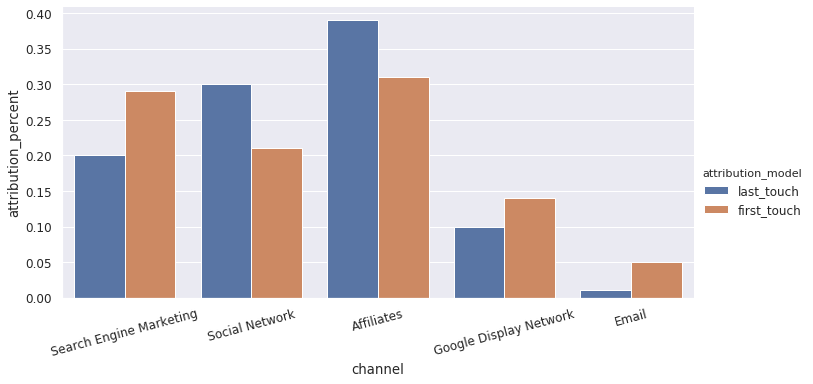

In [0]:
attribution_pd = spark.table('gold_attribution').toPandas()

sns.set(font_scale=1.1)
sns.catplot(x='channel',y='attribution_percent',hue='attribution_model',data=attribution_pd, kind='bar', aspect=2).set_xticklabels(rotation=15)